In [1]:
import collections
import json
import uuid

from PIL import Image

In [2]:
# Helper for displaying images.

# source: http://nbviewer.ipython.org/gist/deeplook/5162445
from io import BytesIO

from IPython import display
from PIL import Image


def display_pil_image(im):
   """Displayhook function for PIL Images, rendered as PNG."""

   b = BytesIO()
   im.save(b, format='png')
   data = b.getvalue()

   ip_img = display.Image(data=data, format='png', embed=True)
   return ip_img._repr_png_()


# register display func with PNG formatter:
png_formatter = get_ipython().display_formatter.formatters['image/png']
dpi = png_formatter.for_type(Image.Image, display_pil_image)

In [ ]:
class Edge:
    def __init__(self, graph, label, target):
        pass


class Node:
    def __init__(self, graph, guid=None):
        if guid is None:
            guid = uuid.uuid4().hex
        self.guid = guid
        self._graph = graph
    
    @property
    def edges(self):
        return self.graph.get_edges(self)


class JSONGraph:
    def __init__(self):
        self._properties = {'guidMap': {}}
    
    @property
    def _guid_map(self):
        return self._properties['guidMap']
    
    @classmethod
    def load(cls, fp):
        graph = cls()
        graph._properties = json.load(f)
    
    def save(self, fp):
        json.dump(core, f, indent=2, sort_keys=True)

    def _to_json(self, target):
        # TODO: switch on type

    def get_edges(self, node):
        pass
        
    def add_edge(self, source, target, label):
        if source.guid not in self._guid_map:
            self._guid_map[source.guid] = {}    
        self._guid_map[source.guid][label.guid] = self._to_json(target)
        

In [3]:
with open("pikov.json") as f:
    core = json.load(f)

guid_map = core["guidMap"]

In [40]:
#json.dumps(core, indent=2, sort_keys=True)

with open("pikov.json", "w") as f:
    json.dump(core, f, indent=2, sort_keys=True)

## Build names mapping

To make it a little easier to check that I'm using the correct guids, construct a mapping from names back to `guid`.

Note: this adds a constraint that no two nodes have the same name, which should not be enforced for general semantic graphs.

In [5]:
names = {}
for key, edges in guid_map.items():
    for edge, value in edges.items():
        if edge == "169a81aefca74e92b45e3fa03c7021df":
            if value["string"] in names:
                raise ValueError('name: "{}" defined twice'.format(value["string"]))
            names[value["string"]] = key
     
# names

## Semantic Graph Helper Classes

We want to wrap our semantic graph with Python classes. This allows us to interact with Python objects to modify the `guid_map`.

### Semantic Graph Properties

These classes encode the core types used in the semantic graph. When classes use these properties, the `guid_map` is updated with the correct serialization of the property.

In [6]:
class AbstractSemanticGraphProperty(object):
    def __init__(self, label_guid):
        self._label_guid = label_guid

    def __get__(self, obj, type=None):
        return self.from_json(obj, obj._edges.get(self._label_guid, {}))

    def __set__(self, obj, value):
        obj._edges[self._label_guid] = self.to_json(value)


class GuidProperty(AbstractSemanticGraphProperty):
    def __init__(self, label_guid, cls):
        super().__init__(label_guid)
        self._cls = cls

    def from_json(self, obj, value):
        guid = value.get("guid")
        if guid is None:
            return None
        return self._cls(obj._guid_map, guid=guid)
    
    def to_json(self, value):
        return {"guid": value.guid}

    
def make_guid_property(wrapped):
    def __init__(self, label_guid):
        GuidProperty.__init__(self, label_guid, wrapped)

    return type(
        wrapped.__name__ + "Property",
        (GuidProperty,),
        {
            "__init__": __init__,
        }
    )

        
class Int64Property(AbstractSemanticGraphProperty):
    def from_json(self, obj, value):
        out = value.get("int64")
        if out is None:
            return None
        return int(out)

    def to_json(self, value):
        return {"int64": str(value)}
            
        
class StringProperty(AbstractSemanticGraphProperty):
    def from_json(self, obj, value):
        return value.get("string")

    def to_json(self, value):
        return {"string": value}

I want all nodes to have an (optional) name property, so define the node class after we've defined the property classes.

In [7]:
class SemanticGraphNode(object):
    def __init__(self, ctor, guid_map, guid=None):
        if guid is None:
            guid = uuid.uuid4().hex
        self.guid = guid
        self._guid_map = guid_map

        if guid in self._guid_map:
            self._edges = self._guid_map[guid]
        else:
            self._edges = {
                names["ctor"]: {"guid": ctor},
            }
            self._guid_map[guid] = self._edges
    
    name = StringProperty(names["name"])
    
    def __repr__(self):
        return '"{}": {}'.format(
            self.guid,
            json.dumps(self._edges, indent=2, sort_keys=True))


## Pikov Classes

These classes are the core resources used in defining a "Pikov" file.

Note: ideally these classes could be derived from the graph itself, but I don't (yet) encode type or field information in the `pikov.json` semantic graph.

In [8]:
class Resource(SemanticGraphNode):
    def __init__(self, guid_map, guid=None):
        super().__init__(names["resource"], guid_map, guid=guid)
        self._image = None

    relative_path = StringProperty(names["resource.relative_path"])
    
    @property
    def image(self):
        if self._image is None:
            self._image = Image.open(self.relative_path)
        return self._image


ResourceProperty = make_guid_property(Resource)

In [9]:
class Coordinate(SemanticGraphNode):
    def __init__(self, guid_map, guid=None):
        super().__init__(names["coordinate"], guid_map, guid=guid)
    
    x = Int64Property(names["coordinate.x"])
    y = Int64Property(names["coordinate.y"])


CoordinateProperty = make_guid_property(Coordinate)

In [10]:
class Vector(SemanticGraphNode):
    def __init__(self, guid_map, guid=None):
        super().__init__(names["vector"], guid_map, guid=guid)
    
    x = Int64Property(names["vector.x"])
    y = Int64Property(names["vector.y"])


VectorProperty = make_guid_property(Vector)

In [11]:
class Rectangle(SemanticGraphNode):
    def __init__(self, guid_map, guid=None):
        super().__init__(names["rectangle"], guid_map, guid=guid)
    
    anchor = CoordinateProperty(names["rectangle.anchor"])
    width = Int64Property(names["rectangle.width"])
    height = Int64Property(names["rectangle.height"])


RectangleProperty = make_guid_property(Rectangle)

In [12]:
class Bitmap(SemanticGraphNode):
    def __init__(self, guid_map, guid=None):
        super().__init__(names["bitmap"], guid_map, guid=guid)
        self._image = None
    
    resource = ResourceProperty(names["bitmap.resource"])
    crop = RectangleProperty(names["bitmap.crop"])
        
    @property
    def image(self):
        if self._image is None:
            left = self.crop.anchor.x
            top = self.crop.anchor.y
            right = left + self.crop.width
            bottom = top + self.crop.height
            self._image = self.resource.image.crop(
                (left, top, right, bottom)
            )
        return self._image
    
    
BitmapProperty = make_guid_property(Bitmap)

In [13]:
class Frame(SemanticGraphNode):
    def __init__(self, guid_map, guid=None):
        super().__init__(names["frame"], guid_map, guid=guid)
    
    duration_microseconds = Int64Property(names["frame.duration_microseconds"])
    bitmap = BitmapProperty(names["frame.bitmap"])


FrameProperty = make_guid_property(Frame)

In [14]:
class Transition(SemanticGraphNode):
    def __init__(self, guid_map, guid=None):
        super().__init__(names["transition"], guid_map, guid=guid)
    
    source = FrameProperty(names["transition.source"])
    target = FrameProperty(names["transition.target"])


TransitionProperty = make_guid_property(Transition)

In [15]:
class Sprite(SemanticGraphNode):
    def __init__(self, guid_map, guid=None):
        super().__init__(names["sprite"], guid_map, guid=guid)
    
    frame = FrameProperty(names["sprite.frame"])
    position = CoordinateProperty(names["sprite.position"])
    
SpriteProperty = make_guid_property(Sprite)

## Gamekitty

Create instances of the Pikov classes to define a concrete Pikov graph, based on my "gamekitty" animations.

In [16]:
resource = Resource(guid_map, guid=names.get("spritesheet"))
resource.name = "spritesheet"
resource.relative_path = "./gamekitty.png"
resource

"710af736fb3945e28b07e0ac3a8e53d6": {
  "169a81aefca74e92b45e3fa03c7021df": {
    "string": "spritesheet"
  },
  "4e09f9df1fdf4eb4964ff9ed1b375dbb": {
    "string": "./gamekitty.png"
  },
  "aba6ac79fd3d409da860a77c90942852": {
    "guid": "6ecf1345ea0b4865b92569971b100b09"
  }
}

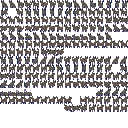

In [17]:
resource.image

### Chop image into 8x8 sprites

By creating an array of 8x8 images, we make it easier to map from PICO-8 sprite number (from my original gamekitty cart) to a Bitmap.

In [18]:
spritesheet = []
for row in range(16):
    for column in range(16):
        sprite_number = row * 16 + column
        
        crop_name = "crop[{}]".format(sprite_number)
        crop = Rectangle(guid_map, guid=names.get(crop_name))
        crop.name = crop_name
        
        anchor_name = "anchor[{}]".format(sprite_number)
        anchor = Coordinate(guid_map, guid=names.get(anchor_name))
        anchor.name = anchor_name
        anchor.x = row * 8
        anchor.y = row * 8

        crop.anchor = anchor
        crop.width = 8
        crop.height = 8
        
        bitmap_name = "bitmap[{}]".format(sprite_number)
        bitmap = Bitmap(guid_map, guid=names.get(bitmap_name))
        bitmap.name = bitmap_name
        bitmap.resource = resource
        bitmap.crop = crop
        
        spritesheet.append(bitmap)

### Create frames for each "clip"

Each animation is defined in terms of sprite numbers. Sometimes a clip should loop, but sometimes it's only used as a transition between looping clips.

In [19]:
MICROS_12_FPS = int(1e6 / 12)  # 12 frames per second
MICROS_24_FPS = int(1e6 / 24)

In [38]:
def find_nodes(guid_map, ctor, cls):
    nodes = {}
    for guid, edges in guid_map.items():
        if edges.get(names["ctor"]) == ctor:
            nodes = cls(guid_map, guid=guid)
            nodes[node.name] = node
    return nodes


def find_frames(guid_map):
    return find_nodes(guid_map, names["frame"], Frame)


def find_transitions(guid_map):
    return find_nodes(guid_map, names["transition"], Transition)


def find_absorbing_frames(guid_map):
    transitions = find_transitions(guid_map)
    target_frames = set()
    source_frames = set()
    for transition in transitions:
        target_frames.add(transition.target.guid)
        source_frames.add(transition.source.guid)
    return target_frames - source_frames  # In but not out. Dead end!

In [21]:
def connect_frames(guid_map, transition_name, source, target):
    transition = Transition(guid_map, guid=names.get(transition_name))
    transition.name = transition_name
    transition.source = source
    transition.target = target
    return transition


def make_clip(guid_map, name, sprite_numbers, loop=False, duration=MICROS_12_FPS):
    clip = []
    previous_sprite_name = None
    for sequence, sprite_number in enumerate(sprite_numbers):
        sprite_name = "{}[{}]".format(name, sequence)
        frame_name = "frames[{}]".format(sprite_name)
        frame = Frame(guid_map, guid=names.get(frame_name))
        frame.name = frame_name
        frame.bitmap = spritesheet[sprite_number]
        frame.duration = duration
        
        if clip:
            transition_name = "transitions[{}, {}]".format(
                previous_sprite_name,
                sprite_name)
            connect_frames(guid_map, transition_name, clip[-1], frame)
        
        previous_sprite_name = sprite_name
        clip.append(frame)
    
    if loop:
        transition_name = "transitions[{}, {}]".format(
            previous_sprite_name,
            "{}[0]".format(name))
        connect_frames(guid_map, transition_name, clip[-1], clip[0])
    
    return clip     

In [22]:
sit = make_clip(guid_map, "sit", [0], loop=True)
sit[0].bitmap.image

In [23]:
sit_to_stand = make_clip(guid_map, "sit_to_stand", [1,2,3,4])

In [24]:
stand_waggle = make_clip(guid_map, "stand_waggle", [26,4], loop=True)

In [25]:
connect_frames(
    guid_map,
    "transitions[sit_to_stand, stand_waggle]",
    sit_to_stand[-1],
    stand_waggle[0])

"406ac656142a45c0a1ff3f1716e84fac": {
  "169a81aefca74e92b45e3fa03c7021df": {
    "string": "transitions[sit_to_stand, stand_waggle]"
  },
  "8ea9b7bc02e748ae9dc2e169590e71e3": {
    "guid": "f6a2db33bca64aa799d3690ced24b187"
  },
  "aba6ac79fd3d409da860a77c90942852": {
    "guid": "8fe06c0750344322bd773f56bdd73b0a"
  },
  "ff7abe687a764f9d80d67a70424c329a": {
    "guid": "e78112cca4b847528b93a8decd55db22"
  }
}

In [26]:
stand_to_sit = make_clip(guid_map, "stand_to_sit", [57, 58, 59, 60, 61])

In [27]:
connect_frames(
    guid_map,
    "transitions[stand_waggle, stand_to_sit]",
    stand_waggle[-1],
    stand_to_sit[0])

"63ba4e0ceac74fd6aa351f00d08d20c2": {
  "169a81aefca74e92b45e3fa03c7021df": {
    "string": "transitions[stand_waggle, stand_to_sit]"
  },
  "8ea9b7bc02e748ae9dc2e169590e71e3": {
    "guid": "0f61052c26164f6dbb9adc9a64570e89"
  },
  "aba6ac79fd3d409da860a77c90942852": {
    "guid": "8fe06c0750344322bd773f56bdd73b0a"
  },
  "ff7abe687a764f9d80d67a70424c329a": {
    "guid": "cade35be593249d68b22a0d7d80db055"
  }
}

### Create the root node

`gamekitty` should be our root node. It's the only object in our scene right now.

In [28]:
origin = Coordinate(guid_map, guid=names.get("origin"))
origin.name = "origin"
origin.x = 0
origin.y = 0
origin

"01188e000bae49ec8c08891e16d25091": {
  "169a81aefca74e92b45e3fa03c7021df": {
    "string": "origin"
  },
  "66b25e276cfb4d83a7032baaa4369b6f": {
    "int64": "0"
  },
  "825142afc2934fbcb5126e149ac5ba31": {
    "int64": "0"
  },
  "aba6ac79fd3d409da860a77c90942852": {
    "guid": "bfa8113cb5e5436ebd76ab5418b7efd1"
  }
}

In [30]:
sprite = Sprite(guid_map, guid=names.get("gamekitty"))
sprite.name = "gamekitty"
core["root"] = sprite.guid
sprite.position = origin
sprite.frame = sit[0]
sprite

"b463421ad4374bda8e088b9602fd8794": {
  "169a81aefca74e92b45e3fa03c7021df": {
    "string": "gamekitty"
  },
  "2175a23088d347cb9256b7f6c6eae310": {
    "guid": "01188e000bae49ec8c08891e16d25091"
  },
  "4b079607f347492c8250059b5c0b2ef6": {
    "guid": "61bf1365bb8b40cbac34d30f7b8c1ac5"
  },
  "aba6ac79fd3d409da860a77c90942852": {
    "guid": "158aafa594b44474a7da66a8cfa419f0"
  }
}

### More clips and transitions

In [31]:
sit_paw = make_clip(guid_map, "sit_paw", [62, 63, 64, 65])

In [32]:
connect_frames(
    guid_map,
    "transitions[sit_paw, sit]",
    sit_paw[-1],
    sit[0])
connect_frames(
    guid_map,
    "transitions[sit, sit_paw]",
    sit[-1],
    sit_paw[0])

"1b42a000d15742a1a49e2e6f3e6193be": {
  "169a81aefca74e92b45e3fa03c7021df": {
    "string": "transitions[sit, sit_paw]"
  },
  "8ea9b7bc02e748ae9dc2e169590e71e3": {
    "guid": "61bf1365bb8b40cbac34d30f7b8c1ac5"
  },
  "aba6ac79fd3d409da860a77c90942852": {
    "guid": "8fe06c0750344322bd773f56bdd73b0a"
  },
  "ff7abe687a764f9d80d67a70424c329a": {
    "guid": "ef8dafd0bb294811b1d16653e25db192"
  }
}

In [33]:
sit_to_crouch = make_clip(guid_map, "sit_to_crouch", [69, 70, 71])
connect_frames(
    guid_map,
    "transitions[sit, sit_to_crouch]",
    sit[-1],
    sit_to_crouch[0])

"a4d39c1cca4742ba8d06cae39a6f1ea2": {
  "169a81aefca74e92b45e3fa03c7021df": {
    "string": "transitions[sit, sit_to_crouch]"
  },
  "8ea9b7bc02e748ae9dc2e169590e71e3": {
    "guid": "61bf1365bb8b40cbac34d30f7b8c1ac5"
  },
  "aba6ac79fd3d409da860a77c90942852": {
    "guid": "8fe06c0750344322bd773f56bdd73b0a"
  },
  "ff7abe687a764f9d80d67a70424c329a": {
    "guid": "92772921661b432988dfaeb4b7be75ed"
  }
}

In [34]:
crouch = make_clip(guid_map, "crouch", [72])
connect_frames(
    guid_map,
    "transitions[crouch, sit_to_crouch]",
    crouch[-1],
    sit_to_crouch[0])

"3d62b1f49c7a43209b2693f54e94b791": {
  "169a81aefca74e92b45e3fa03c7021df": {
    "string": "transitions[crouch, sit_to_crouch]"
  },
  "8ea9b7bc02e748ae9dc2e169590e71e3": {
    "guid": "f0465488f13445b991ec2bbf47f931d8"
  },
  "aba6ac79fd3d409da860a77c90942852": {
    "guid": "8fe06c0750344322bd773f56bdd73b0a"
  },
  "ff7abe687a764f9d80d67a70424c329a": {
    "guid": "92772921661b432988dfaeb4b7be75ed"
  }
}

In [35]:
crouch_to_sit = make_clip(guid_map, "crouch_to_sit", [75, 76, 77])
connect_frames(
    guid_map,
    "transitions[crouch_to_sit, sit]",
    crouch_to_sit[-1],
    sit[0])

"41dc084c788044a083a963d649a58100": {
  "169a81aefca74e92b45e3fa03c7021df": {
    "string": "transitions[crouch_to_sit, sit]"
  },
  "8ea9b7bc02e748ae9dc2e169590e71e3": {
    "guid": "9fc1ab9be057424b936ecdd10949bca9"
  },
  "aba6ac79fd3d409da860a77c90942852": {
    "guid": "8fe06c0750344322bd773f56bdd73b0a"
  },
  "ff7abe687a764f9d80d67a70424c329a": {
    "guid": "61bf1365bb8b40cbac34d30f7b8c1ac5"
  }
}

In [39]:
find_absorbing_frames(guid_map)

set()